In [1]:
# Step 1: Import required libraries
import pandas as pd
import numpy as np

# Step 2: File path
file_path = "/content/LokSabhacandidate_datacombined_2004,2009,201_2019.xlsx"

# Step 3: Load the Excel file
df = pd.read_excel("/content/LokSabhacandidate_datacombined_2004,2009,201_2019.xlsx")



# Step 4: Basic dataset checks (before cleaning)

# Shape of the dataset
print("Shape of dataset (rows, columns):", df.shape)

# Column names
print("\nColumn names:")
print(df.columns.tolist())

# Data types of each column
print("\nData types:")
print(df.dtypes)

# First 5 rows
print("\nSample data:")
print(df.head())

# Summary statistics for numeric columns
print("\nSummary statistics (numeric):")
print(df.describe())

# Summary for object (categorical) columns
print("\nSummary statistics (categorical):")
print(df.describe(include='object'))

# Check missing values per column
print("\nMissing values per column:")
print(df.isnull().sum())

# Check for duplicates
print("\nNumber of duplicate rows:", df.duplicated().sum())

# Count of unique values in each column (useful before cleaning)
print("\nUnique value counts per column:")
for col in df.columns:
    print(f"{col}: {df[col].nunique()}")


Shape of dataset (rows, columns): (28014, 11)

Column names:
['Candidate', 'Party', 'Criminal Cases', 'Education', 'Age', 'Total Assets', 'Constituency', 'Liabilities', 'Winner', 'Gender', 'Year of election']

Data types:
Candidate            object
Party                object
Criminal Cases        int64
Education            object
Age                   int64
Total Assets        float64
Constituency         object
Liabilities           int64
Winner                int64
Gender               object
Year of election      int64
dtype: object

Sample data:
           Candidate Party  Criminal Cases      Education  Age  Total Assets  \
0  Manoranjan Bhakta   INC               0  Post Graduate   65     5926740.0   
1         A K Biswas   BSP               0       Graduate   61     7876500.0   
2   Asit Baran Dutta   IND               0       Graduate   50     3070000.0   
3    Bishnu Pada Ray   BJP               0       Graduate   54     1250619.0   
4      Deepak Biswas   IND               0

In [2]:

import numpy as np
import re
from datetime import datetime
from IPython.display import display


# Keep a raw copy for safety
df_raw = df.copy()

# ---------- helper functions ----------
def parse_indian_amount(x):
    """Parse many common affidavit formats into numeric INR (float)."""
    if pd.isna(x):
        return np.nan
    if isinstance(x, (int, float, np.number)):
        try:
            return float(x)
        except:
            return np.nan
    s = str(x).strip().lower()
    if s in ['', 'na', 'n/a', 'nan', '-', 'not available', 'nil', 'none']:
        return np.nan
    # remove currency words/symbols
    s = s.replace('rs.', '').replace('rs', '').replace('inr', '').replace('rupees', '')
    s = s.replace('—', '-').replace('–', '-')
    s = s.replace('(', '').replace(')', '').replace(' ', '')
    try:
        if 'crore' in s or re.search(r'\bcr\b', s):
            num = re.findall(r'[\d\.,]+', s)
            if num:
                n = num[0].replace(',', '')
                return float(n) * 1e7
            m = re.search(r'(\d+(\.\d+)?)', s)
            return float(m.group(1)) * 1e7 if m else np.nan
        if 'lakh' in s or 'lac' in s:
            num = re.findall(r'[\d\.,]+', s)
            if num:
                n = num[0].replace(',', '')
                return float(n) * 1e5
            m = re.search(r'(\d+(\.\d+)?)', s)
            return float(m.group(1)) * 1e5 if m else np.nan
        if 'thousand' in s or s.endswith('k'):
            num = re.findall(r'[\d\.,]+', s)
            if num:
                n = num[0].replace(',', '')
                return float(n) * 1e3
            m = re.search(r'(\d+(\.\d+)?)', s)
            return float(m.group(1)) * 1e3 if m else np.nan
        if 'million' in s:
            num = re.findall(r'[\d\.,]+', s)
            if num:
                n = num[0].replace(',', '')
                return float(n) * 1e6
            m = re.search(r'(\d+(\.\d+)?)', s)
            return float(m.group(1)) * 1e6 if m else np.nan
        # plain numeric (handles commas)
        numtxt = re.findall(r'[\d\.]+(?:,\d{2,3})*', str(x))
        if numtxt:
            n = numtxt[0].replace(',', '')
            return float(n)
        n = re.sub(r'[^\d\.-]', '', s)
        if n in ['', '.', '-']:
            return np.nan
        return float(n)
    except Exception:
        return np.nan

def extract_num_cases(x):
    """Extract an integer count of criminal cases if possible."""
    if pd.isna(x):
        return 0
    if isinstance(x, (int, float, np.number)):
        try:
            val = int(x)
            return val if val >= 0 else 0
        except:
            return 0
    s = str(x).strip().lower()
    if s in ['', 'na', 'n/a', 'nan', 'nil', 'none', '-']:
        return 0
    m = re.search(r'(\d+)', s)
    if m:
        return int(m.group(1))
    if any(w in s for w in ['case', 'fir', 'charges', 'accused', 'criminal']):
        return 1
    return 0

def detect_serious_crime(x):
    """Keyword-based detection for 'serious' crimes in free-text."""
    if pd.isna(x):
        return False
    s = str(x).lower()
    serious_keywords = [
        'murder','rape','attempt','dowry','kidnap','dacoity','robbery','riots',
        'terror','terrorism','criminalconspiracy','violent','culpable','treason','molestation'
    ]
    for kw in serious_keywords:
        if kw in s:
            return True
    return False

def standardize_education(x):
    """Map education text to standardized categories."""
    if pd.isna(x):
        return 'Unknown'
    s = str(x).strip().lower()
    if s in ['', 'na', 'n/a', 'nan', 'notavailable', 'not available', 'none']:
        return 'Unknown'
    if any(tok in s for tok in ['phd', 'doctor', 'dphil']):
        return 'Doctorate'
    if any(tok in s for tok in ['post', 'postgraduate', 'm.a', 'm.sc', 'msc', 'mba', 'mcom', 'mtech', 'ms']):
        return 'Postgraduate'
    if any(tok in s for tok in ['graduate', 'b.a', 'b.sc', 'ba', 'bcom', 'btech', 'b.e', 'be', 'bba', 'bca']):
        return 'Graduate'
    if any(tok in s for tok in ['law', 'llb', 'medical', 'mbbs', 'ca', 'engineer', 'architect']):
        return 'Professional'
    if any(tok in s for tok in ['10', '10th', 'class 10', 'matric']):
        return 'Secondary'
    if any(tok in s for tok in ['12', '12th', 'class 12', 'higher secondary', 'intermediate']):
        return 'Secondary'
    if 'primary' in s or 'illiterate' in s or 'literate' in s:
        return 'Primary' if 'primary' in s else ('No formal education' if 'illiterate' in s else 'Primary')
    if 'school' in s or 'secondary' in s:
        return 'Secondary'
    if 'degree' in s:
        return 'Graduate'
    return 'Unknown'

def standardize_gender(x):
    """Normalize gender labels."""
    if pd.isna(x):
        return 'Unknown'
    s = str(x).strip().lower()
    if s in ['m', 'male', 'man']:
        return 'Male'
    if s in ['f', 'female', 'woman', 'w']:
        return 'Female'
    if s in ['o', 'other', 'transgender', 'tg', 'trans']:
        return 'Other'
    return 'Unknown'

def standardize_winner(x):
    """Convert winner field to boolean."""
    if pd.isna(x):
        return False
    s = str(x).strip().lower()
    if s in ['yes','y','true','1','winner','won','win']:
        return True
    if s in ['no','n','false','0','lost','loser']:
        return False
    try:
        if float(s) == 1.0:
            return True
        if float(s) == 0.0:
            return False
    except:
        pass
    return False

# ---------- 2. Normalize column names ----------
def normalize_colname(c):
    c = str(c).strip()
    c = re.sub(r'\s+', '_', c)
    c = re.sub(r'[^\w_]', '', c)
    return c.lower()

df.columns = [normalize_colname(c) for c in df.columns]
print("Normalized columns:", df.columns.tolist())

# ---------- 3. Heuristic mapping of expected columns ----------
cols = df.columns.tolist()

def find_col(possible_names):
    for p in possible_names:
        for c in cols:
            if p == c:
                return c
    for p in possible_names:
        for c in cols:
            if p in c:
                return c
    return None

colmap = {}
colmap['candidate'] = find_col(['candidate','name','candidate_name'])
colmap['party'] = find_col(['party','partyname'])
colmap['criminal'] = find_col(['criminal_cases','criminal','criminal_cases_count','criminal_cases_details','criminal_cases_or_fir'])
colmap['education'] = find_col(['education','educational_qualification'])
colmap['age'] = find_col(['age','candidate_age'])
colmap['total_assets'] = find_col(['total_assets','assets','totalassets','asset'])
colmap['liabilities'] = find_col(['liabilities','liability','total_liabilities'])
colmap['constituency'] = find_col(['constituency','constituency_name'])
colmap['winner'] = find_col(['winner','iswinner','won'])
colmap['gender'] = find_col(['gender','sex'])
colmap['year'] = find_col(['year','election_year','year_int'])

print("Detected mapping (may include None if not found):")
for k, v in colmap.items():
    print(f"  {k} => {v}")

# ---------- 4. Trim whitespace & normalize key string columns ----------
for c in df.select_dtypes(include=['object']).columns:
    df[c] = df[c].apply(lambda z: z.strip() if isinstance(z, str) else z)

if colmap['candidate']:
    df[colmap['candidate']] = df[colmap['candidate']].astype(str).str.strip()
if colmap['party']:
    df[colmap['party']] = df[colmap['party']].astype(str).str.strip()
if colmap['constituency']:
    df[colmap['constituency']] = df[colmap['constituency']].astype(str).str.strip().str.title()

# ---------- 5. Remove exact duplicate rows only ----------
before_dup = df.shape[0]
df = df.drop_duplicates()
after_dup = df.shape[0]
print(f"Dropped exact duplicates: {before_dup - after_dup}")

# NOTE: The near-duplicate drop by (candidate, constituency, year) has been removed intentionally.

# ---------- 6. Convert numeric-like fields ----------
# Parse assets & liabilities
if colmap['total_assets']:
    df['total_assets_inr'] = df[colmap['total_assets']].apply(parse_indian_amount)
else:
    df['total_assets_inr'] = np.nan

if colmap['liabilities']:
    df['liabilities_inr'] = df[colmap['liabilities']].apply(parse_indian_amount)
else:
    df['liabilities_inr'] = np.nan

df['net_worth_inr'] = df['total_assets_inr'] - df['liabilities_inr']

# Parse age
if colmap['age']:
    def parse_age(x):
        if pd.isna(x): return np.nan
        if isinstance(x, (int, float, np.number)):
            try:
                return int(x)
            except:
                return np.nan
        s = str(x).strip()
        m = re.search(r'(\d{1,3})', s)
        return int(m.group(1)) if m else np.nan
    df['age_num'] = df[colmap['age']].apply(parse_age)
else:
    df['age_num'] = np.nan

# Criminal cases -> count, raw text, flags
if colmap['criminal']:
    df['criminal_cases_count'] = df[colmap['criminal']].apply(extract_num_cases)
    df['criminal_text_raw'] = df[colmap['criminal']].astype(str)
else:
    df['criminal_cases_count'] = 0
    df['criminal_text_raw'] = np.nan

df['has_criminal'] = df['criminal_cases_count'] > 0
df['has_serious_crime_text'] = df['criminal_text_raw'].apply(detect_serious_crime)

# Education standardization
if colmap['education']:
    df['education_std'] = df[colmap['education']].apply(standardize_education)
else:
    df['education_std'] = 'Unknown'

# Gender standardization
if colmap['gender']:
    df['gender_std'] = df[colmap['gender']].apply(standardize_gender)
else:
    df['gender_std'] = 'Unknown'

# Winner flag
if colmap['winner']:
    df['winner_flag'] = df[colmap['winner']].apply(standardize_winner)
else:
    df['winner_flag'] = False

# Year -> integer
if colmap['year']:
    def parse_year(x):
        if pd.isna(x): return np.nan
        try:
            return int(str(x).strip()[:4])
        except:
            m = re.search(r'(20\d{2}|19\d{2})', str(x))
            return int(m.group(1)) if m else np.nan
    df['year_int'] = df[colmap['year']].apply(parse_year)
else:
    df['year_int'] = np.nan

# Is crorepati (>= 1 crore INR i.e. 10,000,000)
df['is_crorepati'] = df['total_assets_inr'].apply(lambda z: False if pd.isna(z) else (z >= 1e7))

# ---------- 7. Handle missing values (conservative approach) ----------
print("\nMissing values before imputation:")
print(df[['total_assets_inr','liabilities_inr','net_worth_inr','age_num','education_std','gender_std','criminal_cases_count']].isnull().sum())

# Drop rows missing critical identity columns (candidate, constituency) if present
critical_cols = [colmap.get('candidate'), colmap.get('constituency')]
critical_cols = [c for c in critical_cols if c is not None]
if critical_cols:
    before = df.shape[0]
    df = df.dropna(axis=0, subset=critical_cols)
    after = df.shape[0]
    print(f"Dropped rows with missing critical columns {critical_cols}: {before - after}")

# Impute age with median (if available)
if df['age_num'].notna().sum() > 0:
    median_age = int(df['age_num'].median(skipna=True))
    df['age_num'] = df['age_num'].fillna(median_age)
    print("Filled missing ages with median:", median_age)
else:
    print("No age values available to impute.")

# Fill education & gender unknowns
df['education_std'] = df['education_std'].fillna('Unknown')
df['gender_std'] = df['gender_std'].fillna('Unknown')

# If liabilities missing but assets present, set liabilities=0 (common in affidavits)
df.loc[df['liabilities_inr'].isna() & df['total_assets_inr'].notna(), 'liabilities_inr'] = 0.0
df['net_worth_inr'] = df['total_assets_inr'] - df['liabilities_inr']

print("\nMissing values after conservative imputation:")
print(df[['total_assets_inr','liabilities_inr','net_worth_inr','age_num','education_std','gender_std','criminal_cases_count']].isnull().sum())

# ---------- 8. Outlier checks & simple fixes ----------
# Age outliers
if 'age_num' in df.columns and df['age_num'].notna().sum() > 0:
    invalid_age_mask = (df['age_num'] < 18) | (df['age_num'] > 120)
    if invalid_age_mask.any():
        print("Found age outliers (replacing with median):", df.loc[invalid_age_mask, ['age_num']].drop_duplicates().values)
        df.loc[invalid_age_mask, 'age_num'] = median_age

# Negative assets/liabilities -> set to NaN
if 'total_assets_inr' in df.columns:
    neg_assets = (df['total_assets_inr'] < 0)
    if neg_assets.any():
        print("Negative asset values found:", neg_assets.sum())
        df.loc[neg_assets, 'total_assets_inr'] = np.nan
if 'liabilities_inr' in df.columns:
    neg_liab = (df['liabilities_inr'] < 0)
    if neg_liab.any():
        print("Negative liability values found:", neg_liab.sum())
        df.loc[neg_liab, 'liabilities_inr'] = np.nan

# Recompute net worth in case of changes
df['net_worth_inr'] = df['total_assets_inr'] - df['liabilities_inr']

# ---------- 9. Derived columns for analysis ----------
df['log_assets'] = df['total_assets_inr'].apply(lambda x: np.log(x) if (pd.notna(x) and x > 0) else np.nan)
df['asset_bucket'] = pd.cut(df['total_assets_inr'],
                            bins=[-1, 0, 1e5, 1e6, 1e7, 1e8, np.inf],
                            labels=['0', '≤1L', '1L-10L', '10L-1Cr', '≥1Cr', '≥10Cr'])

df['has_criminal_binary'] = df['has_criminal'].astype(int)
df['has_serious_binary'] = df['has_serious_crime_text'].astype(int)

# ---------- 10. Reporting: show summaries ----------
print("\nSUMMARY STATS AFTER CLEANING:")
print("Rows:", df.shape[0])
print("Columns:", df.shape[1])

print("\nSample rows:")
display(df.head(10))

print("\nNumeric summary (assets/liabilities/net worth):")
display(df[['total_assets_inr','liabilities_inr','net_worth_inr']].describe())

print("\nEducation distribution:")
print(df['education_std'].value_counts(dropna=False))
print("\nGender distribution:")
print(df['gender_std'].value_counts(dropna=False))
print("\nHas criminal (count):", int(df['has_criminal_binary'].sum()), "out of", df.shape[0])
print("\nWinner counts:")
print(df['winner_flag'].value_counts())

# ---------- 11. Save cleaned dataset ----------
out_xlsx = "/content/LokSabhacandidate_datacleaned_prelim.xlsx"
out_csv = "/content/LokSabhacandidate_datacleaned_prelim.csv"
df.to_excel(out_xlsx, index=False)
df.to_csv(out_csv, index=False)
print(f"\nSaved cleaned dataset to:\n  {out_xlsx}\n  {out_csv}")

# ---------- 12. Quick checks & bookkeeping ----------
print("\nRows originally:", df_raw.shape[0], "| After cleaning:", df.shape[0], "| Removed:", df_raw.shape[0] - df.shape[0])
created_cols = [c for c in df.columns if c not in df_raw.columns]
print("\nCreated columns (preview):")
print(created_cols)


Normalized columns: ['candidate', 'party', 'criminal_cases', 'education', 'age', 'total_assets', 'constituency', 'liabilities', 'winner', 'gender', 'year_of_election']
Detected mapping (may include None if not found):
  candidate => candidate
  party => party
  criminal => criminal_cases
  education => education
  age => age
  total_assets => total_assets
  liabilities => liabilities
  constituency => constituency
  winner => winner
  gender => gender
  year => year_of_election
Dropped exact duplicates: 0

Missing values before imputation:
total_assets_inr        815
liabilities_inr           0
net_worth_inr           815
age_num                   0
education_std             0
gender_std                0
criminal_cases_count      0
dtype: int64
Dropped rows with missing critical columns ['candidate', 'constituency']: 0
Filled missing ages with median: 46

Missing values after conservative imputation:
total_assets_inr        815
liabilities_inr           0
net_worth_inr           815
ag

,candidate,party,criminal_cases,education,age,total_assets,constituency,liabilities,winner,gender,...,has_serious_crime_text,education_std,gender_std,winner_flag,year_int,is_crorepati,log_assets,asset_bucket,has_criminal_binary,has_serious_binary
0,Manoranjan Bhakta,INC,0,Post Graduate,65,5926740.0,Andaman & Nicobar Islands,272061,1,M,...,False,Postgraduate,Male,True,2004,False,15.594985,10L-1Cr,0,0
1,A K Biswas,BSP,0,Graduate,61,7876500.0,Andaman & Nicobar Islands,65000,0,M,...,False,Graduate,Male,False,2004,False,15.879394,10L-1Cr,0,0
2,Asit Baran Dutta,IND,0,Graduate,50,3070000.0,Andaman & Nicobar Islands,0,0,M,...,False,Graduate,Male,False,2004,False,14.937188,10L-1Cr,0,0
3,Bishnu Pada Ray,BJP,0,Graduate,54,1250619.0,Andaman & Nicobar Islands,128710,0,M,...,False,Graduate,Male,False,2004,False,14.039149,10L-1Cr,0,0
4,Deepak Biswas,IND,0,Not Given,28,3000.0,Andaman & Nicobar Islands,0,0,M,...,False,Unknown,Male,False,2004,False,8.006368,≤1L,0,0
5,Dr Shanmugam,LJNSP,0,Doctorate,66,6166416.0,Andaman & Nicobar Islands,67070,0,M,...,False,Doctorate,Male,False,2004,False,15.634628,10L-1Cr,0,0
6,Gour Chandra Majumder,IND,0,Graduate,37,36200.0,Andaman & Nicobar Islands,0,0,M,...,False,Graduate,Male,False,2004,False,10.496814,≤1L,0,0
7,K Kalimuthu,IND,1,8th Pass,51,472440.0,Andaman & Nicobar Islands,73878,0,M,...,False,Unknown,Male,False,2004,False,13.065666,1L-10L,1,0
8,K Perumal,SWD,0,Literate,65,7752141.0,Andaman & Nicobar Islands,0,0,M,...,False,Primary,Male,False,2004,False,15.863480,10L-1Cr,0,0
9,N K P Nair,CPI(ML)(L),0,Literate,49,772588.0,Andaman & Nicobar Islands,188000,0,M,...,False,Primary,Male,False,2004,False,13.557501,1L-10L,0,0



Numeric summary (assets/liabilities/net worth):


,total_assets_inr,liabilities_inr,net_worth_inr
count,2.719900e+04,2.801400e+04,2.719900e+04
mean,3.433395e+07,3.086273e+06,3.115587e+07
std,5.572976e+08,3.400576e+07,5.522143e+08
min,2.000000e+00,0.000000e+00,-6.279800e+08
25%,3.302960e+05,0.000000e+00,2.826250e+05
50%,1.851000e+06,0.000000e+00,1.647587e+06
75%,8.663450e+06,2.700000e+05,7.815488e+06
max,7.710296e+10,2.218003e+09,7.710296e+10



Education distribution:
education_std
Graduate               8020
Secondary              7855
Unknown                5302
Postgraduate           4606
Primary                1181
Doctorate               672
No formal education     378
Name: count, dtype: int64

Gender distribution:
gender_std
Male      26750
Female     1264
Name: count, dtype: int64

Has criminal (count): 4577 out of 28014

Winner counts:
winner_flag
False    26959
True      1055
Name: count, dtype: int64

Saved cleaned dataset to:
  /content/LokSabhacandidate_datacleaned_prelim.xlsx
  /content/LokSabhacandidate_datacleaned_prelim.csv

Rows originally: 28014 | After cleaning: 28014 | Removed: 0

Created columns (preview):
['candidate', 'party', 'criminal_cases', 'education', 'age', 'total_assets', 'constituency', 'liabilities', 'winner', 'gender', 'year_of_election', 'total_assets_inr', 'liabilities_inr', 'net_worth_inr', 'age_num', 'criminal_cases_count', 'criminal_text_raw', 'has_criminal', 'has_serious_crime_text', 

ROWS: 28014  COLUMNS: 28

COLUMNS preview:
['candidate', 'party', 'criminal_cases', 'education', 'age', 'total_assets', 'constituency', 'liabilities', 'winner', 'gender', 'year_of_election', 'total_assets_inr', 'liabilities_inr', 'net_worth_inr', 'age_num', 'criminal_cases_count', 'criminal_text_raw', 'has_criminal', 'has_serious_crime_text', 'education_std', 'gender_std', 'winner_flag', 'year_int', 'is_crorepati', 'log_assets', 'asset_bucket', 'has_criminal_binary', 'has_serious_binary']

Numeric summary (describe):


,count,mean,std,min,25%,50%,75%,max
criminal_cases,28014.0,4.839009e-01,4.164205e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,3.820000e+02
age,28014.0,4.648708e+01,1.254624e+01,0.000000e+00,37.000000,4.600000e+01,5.500000e+01,9.400000e+01
total_assets,27199.0,3.433395e+07,5.572976e+08,2.000000e+00,330296.000000,1.851000e+06,8.663450e+06,7.710296e+10
liabilities,28014.0,3.086273e+06,3.400576e+07,0.000000e+00,0.000000,0.000000e+00,2.700000e+05,2.218003e+09
winner,28014.0,3.765974e-02,1.903754e-01,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,1.000000e+00
year_of_election,28014.0,2.012709e+03,5.050962e+00,2.004000e+03,2009.000000,2.014000e+03,2.019000e+03,2.019000e+03
total_assets_inr,27199.0,3.433395e+07,5.572976e+08,2.000000e+00,330296.000000,1.851000e+06,8.663450e+06,7.710296e+10
liabilities_inr,28014.0,3.086273e+06,3.400576e+07,0.000000e+00,0.000000,0.000000e+00,2.700000e+05,2.218003e+09
net_worth_inr,27199.0,3.115587e+07,5.522143e+08,-6.279800e+08,282625.000000,1.647587e+06,7.815488e+06,7.710296e+10
age_num,28014.0,4.679071e+01,1.196071e+01,2.100000e+01,38.000000,4.600000e+01,5.500000e+01,9.400000e+01



Categorical summary (top values):


,count,unique,top,freq
candidate,28014,23928,Ashok Kumar,31
party,28014,1332,IND,11725
education,28014,12,Graduate,5305
constituency,28014,762,Nizamabad,215
gender,28014,2,M,26750
criminal_text_raw,28014,49,0,23437
education_std,28014,7,Graduate,8020
gender_std,28014,2,Male,26750
asset_bucket,27199,5,10L-1Cr,10006



Missing values (top 20 columns):


,0
total_assets_inr,815
total_assets,815
asset_bucket,815
net_worth_inr,815
log_assets,815
education,0
constituency,0
age,0
liabilities,0
criminal_cases,0



--- QUICK INSIGHTS ---
Crorepati rate (overall): 22.49%
Candidates with any criminal case: 16.34% (4577 candidates)
Winners in dataset: 1055  ( 3.77%  of rows )
Median assets (INR): 1,851,000  Mean assets (INR): 34,333,949
Asset distribution Gini: 0.921


<Figure size 800x400 with 0 Axes>

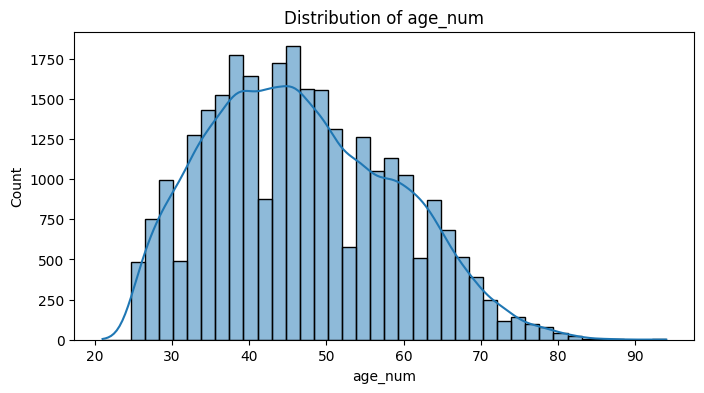

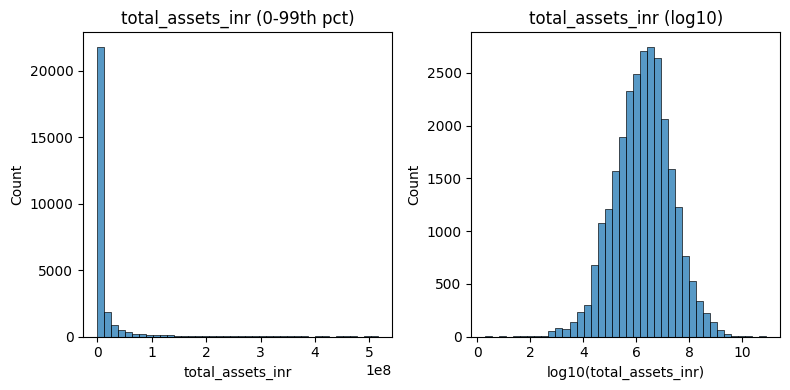

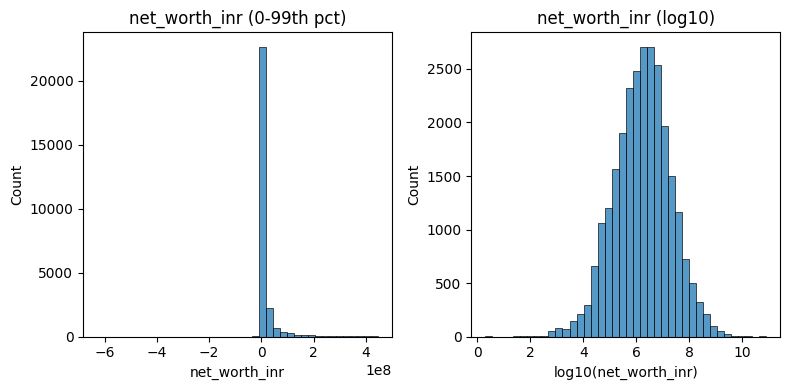

<Figure size 800x400 with 0 Axes>

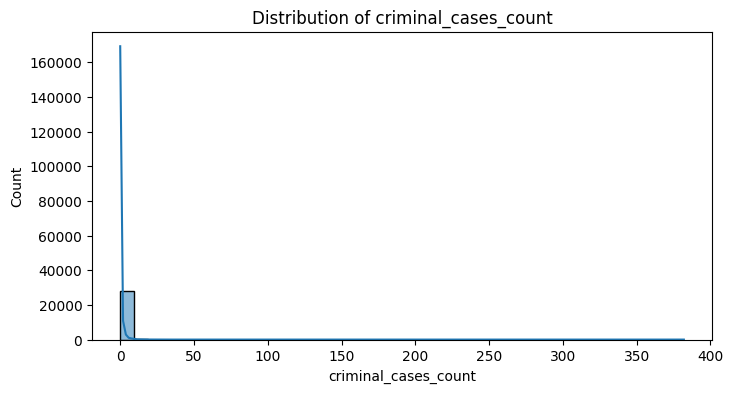

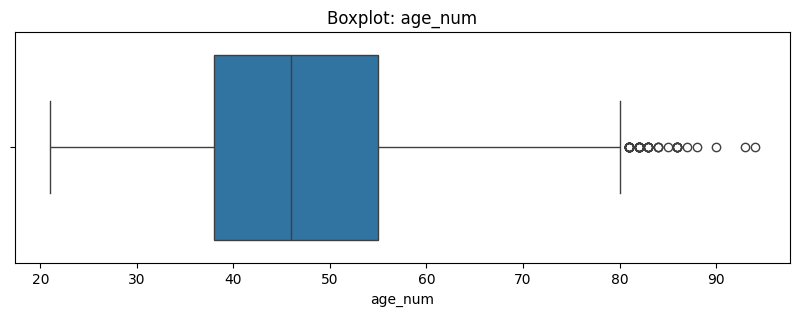

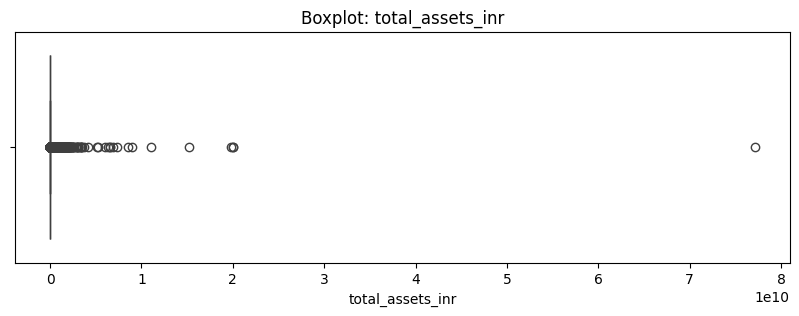

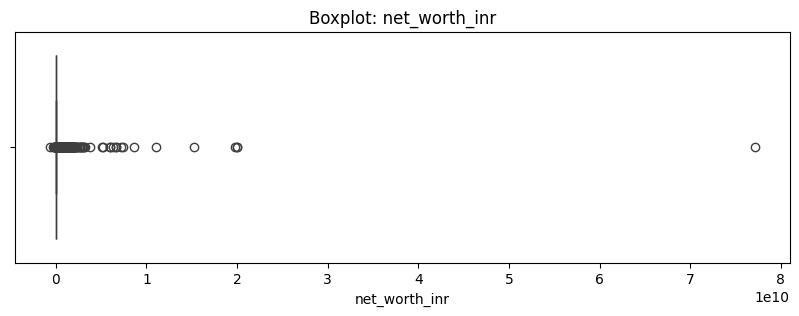

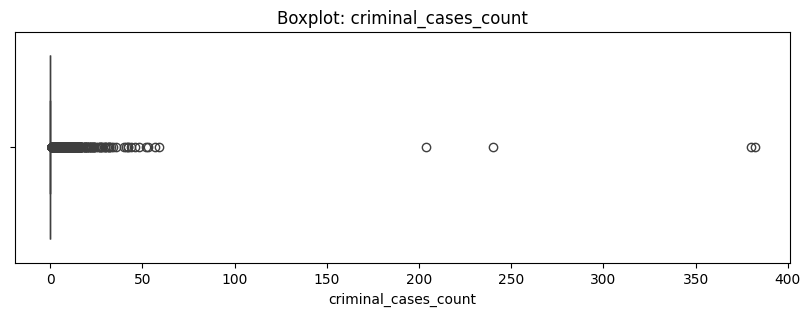

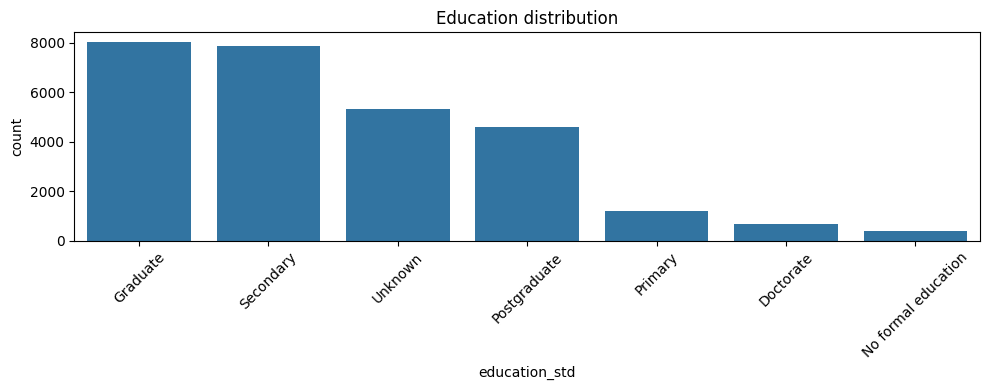

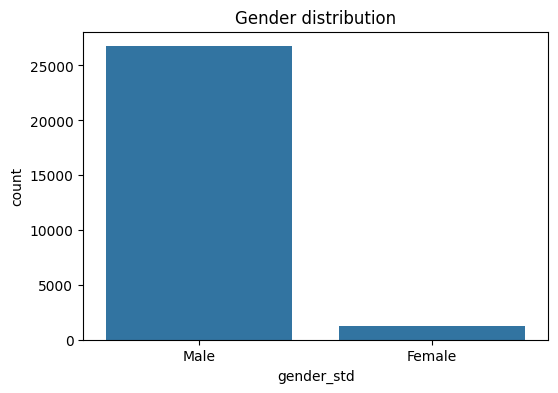


Win rate by gender (rows sum to 1):


winner_flag,False,True
gender_std,,
Female,0.896361,0.103639
Male,0.965458,0.034542


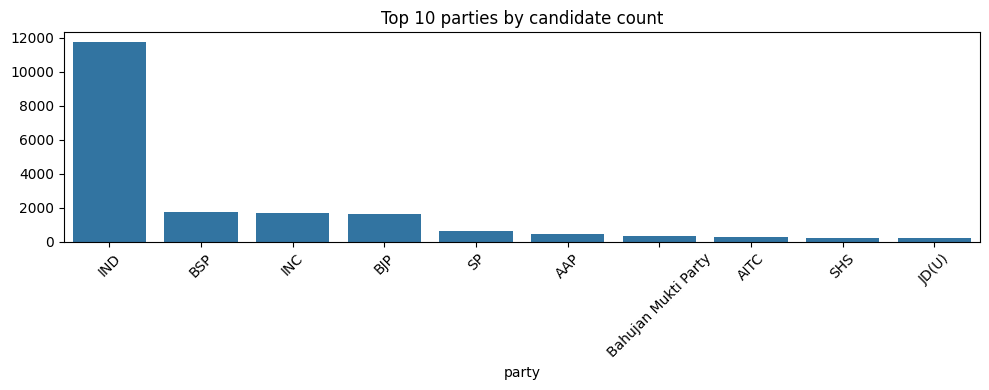


Party-level summary (top 10 parties):


,n,pct_crorepati,pct_with_criminal,winner_rate
party,,,,
AAP,466,0.463519,0.158798,0.002146
AITC,260,0.388462,0.188462,0.111538
BJP,1643,0.577602,0.306756,0.216677
BSP,1724,0.266241,0.208237,0.017981
Bahujan Mukti Party,356,0.137640,0.132022,0.000000
INC,1715,0.672886,0.272886,0.169096
IND,11725,0.092793,0.096375,0.001109
JD(U),216,0.393519,0.384259,0.092593
SHS,245,0.363265,0.367347,0.053061


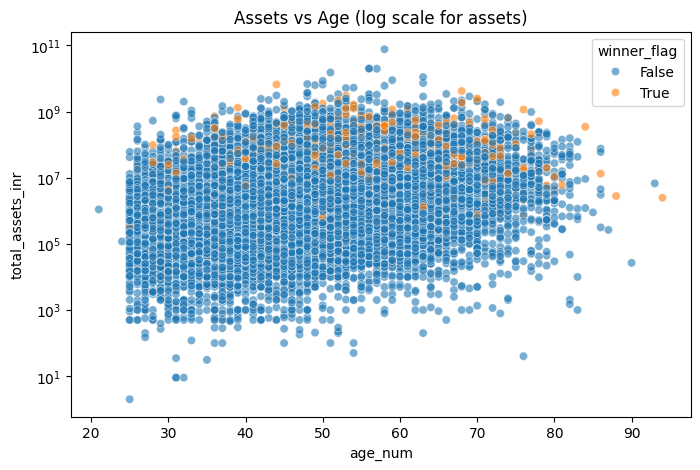

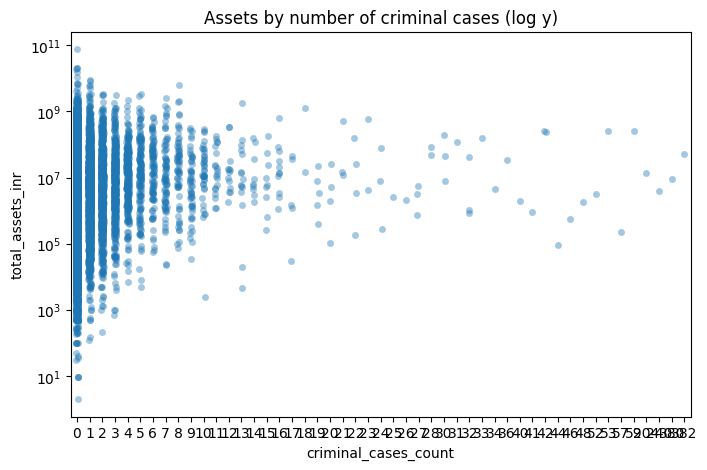

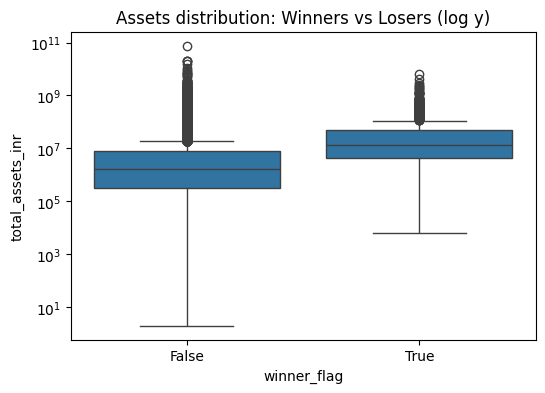


Pearson correlation:


,age_num,total_assets_inr,liabilities_inr,net_worth_inr,criminal_cases_count,has_criminal_binary,winner_flag
age_num,1.000000,0.038088,0.041823,0.035864,0.018775,0.055829,0.120948
total_assets_inr,0.038088,1.000000,0.177599,0.998107,0.007939,0.024291,0.019839
liabilities_inr,0.041823,0.177599,1.000000,0.116745,0.021608,0.067089,0.045605
net_worth_inr,0.035864,0.998107,0.116745,1.000000,0.006678,0.020347,0.017203
criminal_cases_count,0.018775,0.007939,0.021608,0.006678,1.000000,0.262962,-0.022988
has_criminal_binary,0.055829,0.024291,0.067089,0.020347,0.262962,1.000000,-0.087421
winner_flag,0.120948,0.019839,0.045605,0.017203,-0.022988,-0.087421,1.000000



Spearman correlation:


,age_num,total_assets_inr,liabilities_inr,net_worth_inr,criminal_cases_count,has_criminal_binary,winner_flag
age_num,1.000000,0.399274,0.154893,0.401936,0.063979,0.063199,0.117748
total_assets_inr,0.399274,1.000000,0.516063,0.979893,0.204870,0.199988,0.180301
liabilities_inr,0.154893,0.516063,1.000000,0.432191,0.185451,0.180585,0.111850
net_worth_inr,0.401936,0.979893,0.432191,1.000000,0.193188,0.188723,0.176808
criminal_cases_count,0.063979,0.204870,0.185451,0.193188,1.000000,0.995489,-0.087026
has_criminal_binary,0.063199,0.199988,0.180585,0.188723,0.995489,1.000000,-0.087421
winner_flag,0.117748,0.180301,0.111850,0.176808,-0.087026,-0.087421,1.000000


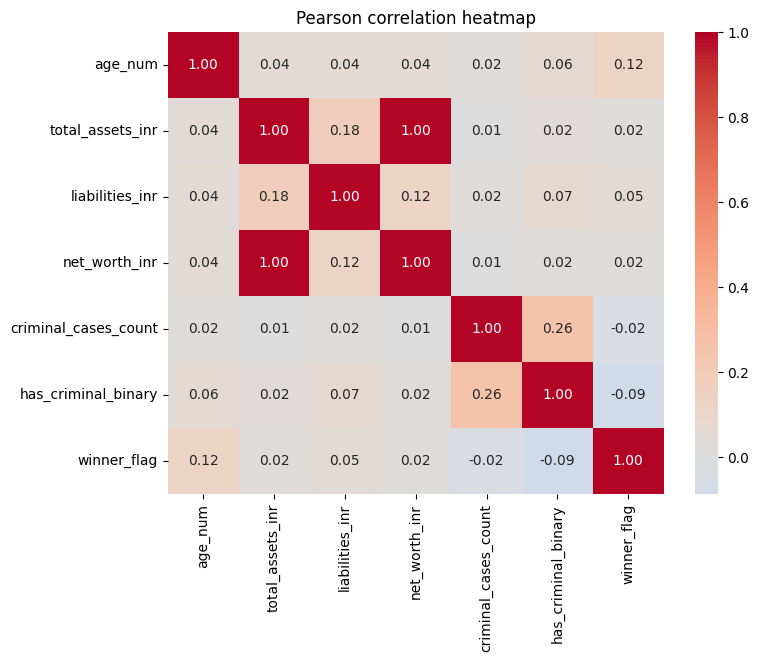


Winners: 1055 | Losers: 26959
Compare assets (W vs L): Mann-Whitney U p-value = 2.719e-194
Median assets W: 13,267,020  L: 1,685,920
Criminal prevalence difference z-test p-value = 1.758e-48
Winners criminal rate: 0.00% Losers: 16.98%

Top 20 wealthiest candidates (preview):


,candidate,party,constituency,year_int,total_assets_inr,has_criminal_binary
13963,Nandan Nilekani,INC,Bangalore South,2014,7.710296e+10,0
19803,Shamali Das,IND,Jadavpur,2014,2.000006e+10,0
19870,Shamali Das,IND,Kolkata Dakshin,2014,2.000006e+10,0
9045,Mohanraj J,JJ,Chennai South,2009,1.977525e+10,0
1432,Srikantadatta Narasimharaja Wadiyar,INC,Mysore,2004,1.522455e+10,0
20922,Ramesh Kumar Sharma,IND,Pataliputra,2019,1.107583e+10,0
26111,Konda Vishweshwar Reddy,INC,Chevella,2019,8.950179e+09,1
12249,Anil Kumar Sharma,JD(U),Jahanabad,2014,8.498804e+09,1
16493,Swaran Salaria,BJP,Gurdaspur : Bye Election On 11-10-2017,2014,7.308956e+09,0
11659,Jayadev Galla,TDP,Guntur,2014,6.830581e+09,0



Wealthy (top20) candidates with criminal cases:


,candidate,party,constituency,year_int,total_assets_inr,has_criminal_binary
26111,Konda Vishweshwar Reddy,INC,Chevella,2019,8.950179e+09,1
12249,Anil Kumar Sharma,JD(U),Jahanabad,2014,8.498804e+09,1
11758,Ayodhya Rami Reddy Alla,Yuvajana Sramika Rythu Congress Party,Narasaraopet,2014,6.543382e+09,1
10838,V. M. Singh,INC,Pilibhit,2009,6.321567e+09,1
8194,Deepak Bhardwaj,BSP,West Delhi,2009,6.038347e+09,1
5568,Khimjibhai Harjivanbhai Patadiya,KKJHS,Surendranagar,2009,5.149728e+09,1
20345,Prasad Veera Potluri,YSRCP,Vijayawada,2019,3.477616e+09,1
20963,Uday Singh,INC,Purnia,2019,3.418644e+09,1



Yearly summary:


,year_int,n_candidates,crorepati_rate,mean_assets
0,2004,3642,0.114772,1.234534e+07
1,2009,7920,0.160732,1.855305e+07
2,2014,8484,0.271099,5.004737e+07
3,2019,7968,0.289784,4.200752e+07


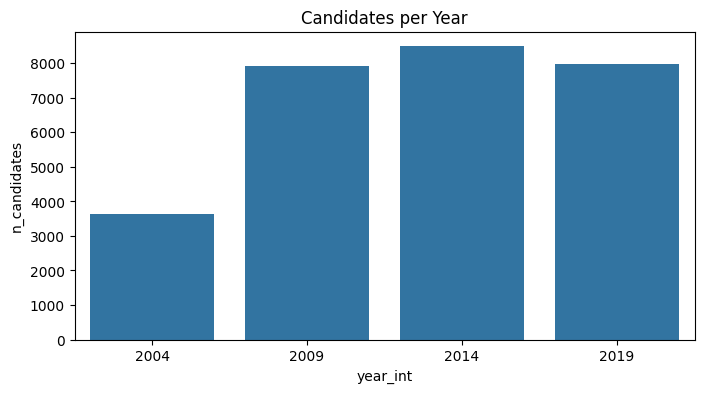

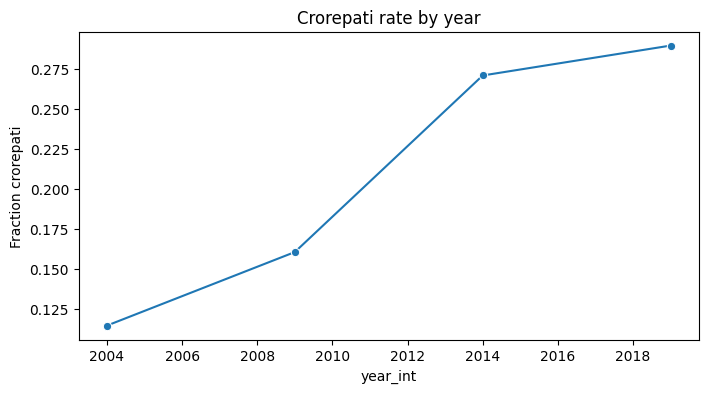

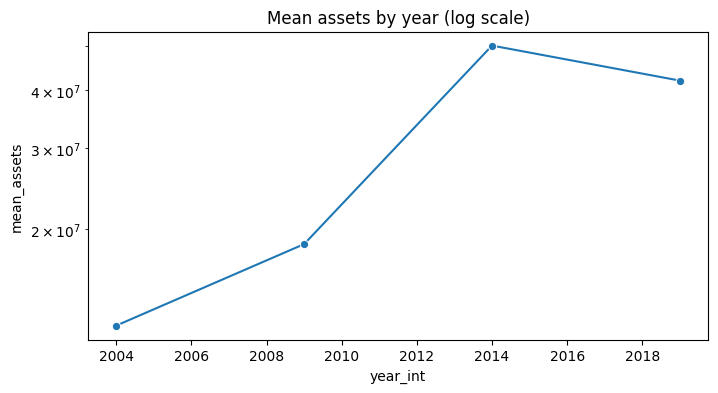


EDA completed. Plots and CSVs saved to: /content/eda_plots


In [4]:

import os
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
%matplotlib inline


# Create output folder for plots
outdir = "/content/eda_plots"
os.makedirs(outdir, exist_ok=True)

# --- Helper functions ---
def safe_col(c):
    return c in df.columns

def gini(array):
    """Compute Gini coefficient of array (non-negative)."""
    array = np.array([x for x in array if (not pd.isna(x)) and x >= 0])
    if array.size == 0:
        return np.nan
    array = np.sort(array)
    n = array.size
    index = np.arange(1, n+1)
    return (2.0 * np.sum(index * array) / (n * np.sum(array))) - (n + 1) / n

def pct(x, digits=2):
    return f"{(100*x):.{digits}f}%"

# --- 1. Basic overview & descriptive stats ---
print("ROWS:", df.shape[0], " COLUMNS:", df.shape[1])
print("\nCOLUMNS preview:")
print(df.columns.tolist())

print("\nNumeric summary (describe):")
display(df.describe(include=[np.number]).T)

print("\nCategorical summary (top values):")
display(df.describe(include=['object', 'category']).T)

print("\nMissing values (top 20 columns):")
display(df.isnull().sum().sort_values(ascending=False).head(20))

# --- 2. Key single-value insights (printable) ---
print("\n--- QUICK INSIGHTS ---")
# percent crorepati
if safe_col('is_crorepati'):
    valid = df['is_crorepati'].notna().sum()
    if valid>0:
        crorepati_rate = df['is_crorepati'].mean()
        print("Crorepati rate (overall):", pct(crorepati_rate))
# percent with criminal cases
if safe_col('has_criminal_binary'):
    print("Candidates with any criminal case:", pct(df['has_criminal_binary'].mean()), f"({int(df['has_criminal_binary'].sum())} candidates)")
# winners count
if safe_col('winner_flag'):
    wins = df['winner_flag'].sum()
    print("Winners in dataset:", wins, " (", pct(wins / df.shape[0]), " of rows )")
# median assets
if safe_col('total_assets_inr'):
    med_assets = df['total_assets_inr'].median(skipna=True)
    mean_assets = df['total_assets_inr'].mean(skipna=True)
    print("Median assets (INR):", f"{med_assets:,.0f}", " Mean assets (INR):", f"{mean_assets:,.0f}")
# asset Gini
if safe_col('total_assets_inr'):
    print("Asset distribution Gini:", round(gini(df['total_assets_inr'].fillna(0)), 3))

# --- 3. Distribution plots: Age, Assets, Net worth, Criminal cases ---
plot_numeric = []
for c in ['age_num','total_assets_inr','net_worth_inr','criminal_cases_count']:
    if safe_col(c):
        plot_numeric.append(c)

for col in plot_numeric:
    plt.figure(figsize=(8,4))
    # For assets/net worth, plot both linear and log (if numeric range wide)
    if col in ['total_assets_inr','net_worth_inr']:
        # linear (zoomed) + log
        nonnull = df[col].dropna()
        q99 = nonnull.quantile(0.99) if not nonnull.empty else 0
        # linear histogram (trim top 1% to show body)
        plt.subplot(1,2,1)
        sns.histplot(nonnull[nonnull <= q99], bins=40, kde=False)
        plt.title(f"{col} (0-99th pct)")
        plt.xlabel(col)
        # log histogram
        plt.subplot(1,2,2)
        positive = nonnull[nonnull>0]
        if not positive.empty:
            sns.histplot(np.log10(positive), bins=40, kde=False)
            plt.xlabel("log10("+col+")")
            plt.title(f"{col} (log10)")
        else:
            plt.text(0.5, 0.5, "No positive values", ha='center')
        plt.tight_layout()
        plt.savefig(os.path.join(outdir, f"dist_{col}.png"), dpi=150)
        plt.show()
    else:
        plt.figure(figsize=(8,4))
        sns.histplot(df[col].dropna(), bins=40, kde=True)
        plt.title(f"Distribution of {col}")
        plt.xlabel(col)
        plt.savefig(os.path.join(outdir, f"dist_{col}.png"), dpi=150)
        plt.show()

# Boxplots to examine outliers
for col in ['age_num','total_assets_inr','net_worth_inr','criminal_cases_count']:
    if safe_col(col):
        plt.figure(figsize=(10,3))
        sns.boxplot(x=df[col].dropna())
        plt.title("Boxplot: " + col)
        plt.savefig(os.path.join(outdir, f"box_{col}.png"), dpi=150)
        plt.show()

# --- 4. Categorical distributions & winners by category ---
# Education distribution
if safe_col('education_std'):
    plt.figure(figsize=(10,4))
    order = df['education_std'].value_counts().index
    sns.countplot(data=df, x='education_std', order=order)
    plt.xticks(rotation=45)
    plt.title("Education distribution")
    plt.tight_layout()
    plt.savefig(os.path.join(outdir,"cat_education.png"), dpi=150)
    plt.show()

# Gender distribution & win rates by gender
if safe_col('gender_std'):
    plt.figure(figsize=(6,4))
    sns.countplot(data=df, x='gender_std', order=df['gender_std'].value_counts().index)
    plt.title("Gender distribution")
    plt.savefig(os.path.join(outdir,"cat_gender.png"), dpi=150)
    plt.show()
    if safe_col('winner_flag'):
        gender_win = pd.crosstab(df['gender_std'], df['winner_flag'], normalize='index')
        print("\nWin rate by gender (rows sum to 1):")
        display(gender_win)

# Party-level: top parties by frequency and their crorepati/criminal rates
if safe_col('party'):
    top_parties = df['party'].value_counts().head(10).index.tolist()
    party_counts = df['party'].value_counts().loc[top_parties]
    plt.figure(figsize=(10,4))
    sns.barplot(x=party_counts.index, y=party_counts.values)
    plt.title("Top 10 parties by candidate count")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(os.path.join(outdir,"top10_parties.png"), dpi=150)
    plt.show()
    # party-level crorepati & criminal %
    party_summary = df[df['party'].isin(top_parties)].groupby('party').agg(
        n=('candidate', 'count') if safe_col('candidate') else ('party','count'),
        pct_crorepati=('is_crorepati', lambda s: np.nanmean(s) if s.dtype=='bool' or s.dtype=='int' else np.nan),
        pct_with_criminal=('has_criminal_binary', 'mean') if safe_col('has_criminal_binary') else ('has_criminal_binary','mean'),
        winner_rate=('winner_flag', 'mean') if safe_col('winner_flag') else ('winner_flag','mean')
    )
    # attempt to clean display for any NaNs
    print("\nParty-level summary (top 10 parties):")
    display(party_summary.fillna("NA"))

# --- 5. Scatter plots and relationships ---
# assets vs age (log scale for assets)
if safe_col('age_num') and safe_col('total_assets_inr'):
    plt.figure(figsize=(8,5))
    sns.scatterplot(data=df, x='age_num', y='total_assets_inr', hue='winner_flag' if safe_col('winner_flag') else None, alpha=0.6)
    plt.yscale('log')
    plt.title("Assets vs Age (log scale for assets)")
    plt.savefig(os.path.join(outdir,"scatter_assets_age.png"), dpi=150)
    plt.show()

# assets vs criminal cases
if safe_col('criminal_cases_count') and safe_col('total_assets_inr'):
    plt.figure(figsize=(8,5))
    sns.stripplot(data=df, x='criminal_cases_count', y='total_assets_inr', jitter=True, alpha=0.4)
    plt.yscale('log')
    plt.title("Assets by number of criminal cases (log y)")
    plt.savefig(os.path.join(outdir,"scatter_assets_crime.png"), dpi=150)
    plt.show()

# Boxplot of assets by winner/loser
if safe_col('winner_flag') and safe_col('total_assets_inr'):
    plt.figure(figsize=(6,4))
    sns.boxplot(data=df, x='winner_flag', y='total_assets_inr')
    plt.yscale('log')
    plt.title("Assets distribution: Winners vs Losers (log y)")
    plt.savefig(os.path.join(outdir,"box_assets_winner.png"), dpi=150)
    plt.show()

# --- 6. Correlations (Pearson & Spearman) ---
corr_cols = [c for c in ['age_num','total_assets_inr','liabilities_inr','net_worth_inr','criminal_cases_count','has_criminal_binary','winner_flag'] if safe_col(c)]
if len(corr_cols) >= 2:
    corr_df = df[corr_cols].copy()
    # Pearson
    pearson = corr_df.corr(method='pearson')
    spearman = corr_df.corr(method='spearman')
    print("\nPearson correlation:")
    display(pearson)
    print("\nSpearman correlation:")
    display(spearman)
    # Heatmap (Pearson)
    plt.figure(figsize=(8,6))
    sns.heatmap(pearson, annot=True, fmt=".2f", cmap='coolwarm', center=0)
    plt.title("Pearson correlation heatmap")
    plt.savefig(os.path.join(outdir,"corr_heatmap_pearson.png"), dpi=150)
    plt.show()

# --- 7. Compare winners vs losers (t-test / Mann-Whitney) ---
if safe_col('winner_flag'):
    winners = df[df['winner_flag'] == True]
    losers = df[df['winner_flag'] == False]
    print(f"\nWinners: {len(winners)} | Losers: {len(losers)}")
    # assets
    if safe_col('total_assets_inr'):
        w_assets = winners['total_assets_inr'].dropna()
        l_assets = losers['total_assets_inr'].dropna()
        if (len(w_assets) > 10) and (len(l_assets) > 10):
            # distributions skewed -> Mann-Whitney U test
            stat, p = stats.mannwhitneyu(w_assets, l_assets, alternative='two-sided')
            print(f"Compare assets (W vs L): Mann-Whitney U p-value = {p:.4g}")
            print("Median assets W:", f"{w_assets.median():,.0f}", " L:", f"{l_assets.median():,.0f}")
        else:
            print("Not enough data for robust assets test (need >10 per group).")
    # criminal cases prevalence
    if safe_col('has_criminal_binary'):
        w_crim = winners['has_criminal_binary'].dropna().astype(int)
        l_crim = losers['has_criminal_binary'].dropna().astype(int)
        # proportion test
        from statsmodels.stats.proportion import proportions_ztest
        count = np.array([w_crim.sum(), l_crim.sum()])
        nobs = np.array([len(w_crim), len(l_crim)])
        if nobs.min() >= 5:
            stat, pval = proportions_ztest(count, nobs)
            print(f"Criminal prevalence difference z-test p-value = {pval:.4g}")
            print("Winners criminal rate:", pct(w_crim.mean()), "Losers:", pct(l_crim.mean()))
        else:
            print("Not enough sample size for proportion z-test.")

# --- 8. Outlier detection: top wealthy & wealthy with criminal cases ---
if safe_col('total_assets_inr'):
    top20 = df[['candidate','party','constituency','year_int','total_assets_inr','has_criminal_binary']].sort_values('total_assets_inr', ascending=False).head(20)
    print("\nTop 20 wealthiest candidates (preview):")
    display(top20)
    wealthy_with_crime = top20[top20['has_criminal_binary']==1]
    if not wealthy_with_crime.empty:
        print("\nWealthy (top20) candidates with criminal cases:")
        display(wealthy_with_crime)

# --- 9. Trends over years: counts, crorepati share, mean assets (if year present) ---
if safe_col('year_int'):
    yearly = df.groupby('year_int').agg(
        n_candidates=('candidate','count') if safe_col('candidate') else ('year_int','count'),
        crorepati_rate=('is_crorepati', 'mean') if safe_col('is_crorepati') else ('is_crorepati','mean'),
        mean_assets=('total_assets_inr','mean') if safe_col('total_assets_inr') else ('total_assets_inr','mean')
    ).reset_index()
    print("\nYearly summary:")
    display(yearly)
    # plots
    plt.figure(figsize=(8,4))
    sns.barplot(data=yearly, x='year_int', y='n_candidates')
    plt.title("Candidates per Year")
    plt.savefig(os.path.join(outdir,"yearly_count.png"), dpi=150)
    plt.show()
    if safe_col('is_crorepati'):
        plt.figure(figsize=(8,4))
        sns.lineplot(data=yearly, x='year_int', y='crorepati_rate', marker='o')
        plt.title("Crorepati rate by year")
        plt.ylabel("Fraction crorepati")
        plt.savefig(os.path.join(outdir,"yearly_crorepati.png"), dpi=150)
        plt.show()
    if safe_col('total_assets_inr'):
        plt.figure(figsize=(8,4))
        sns.lineplot(data=yearly, x='year_int', y='mean_assets', marker='o')
        plt.yscale('log')
        plt.title("Mean assets by year (log scale)")
        plt.savefig(os.path.join(outdir,"yearly_mean_assets.png"), dpi=150)
        plt.show()

# --- 10. Save summary tables for reporting ---
# Save group summaries (party, year, education)
if safe_col('party'):
    df.groupby('party').agg(
        n=('candidate','count') if safe_col('candidate') else ('party','count'),
        pct_crorepati=('is_crorepati', 'mean') if safe_col('is_crorepati') else (None,None),
        pct_with_criminal=('has_criminal_binary', 'mean') if safe_col('has_criminal_binary') else (None,None)
    ).to_csv(os.path.join(outdir, "party_summary.csv"))

if safe_col('education_std'):
    df.groupby('education_std').agg(n=('candidate','count') if safe_col('candidate') else ('education_std','count'),
                                   winner_rate=('winner_flag','mean') if safe_col('winner_flag') else ('winner_flag','mean')
                                  ).to_csv(os.path.join(outdir, "education_summary.csv"))

print("\nEDA completed. Plots and CSVs saved to:", outdir)


Using columns:
 candidate: candidate
 party: party
 constituency: constituency
 gender: gender_std
 assets: total_assets_inr
 education: education_std
 year: year_int
 criminal: has_criminal_binary
 winner: winner_flag


1) Women candidate assets vs Men candidate assets

Assets summary by gender:


,count,median,mean,std,min,max,sum
gender_std,,,,,,,
Male,25966,1851000.0,3.446531e+07,5.693800e+08,2.0,7.710296e+10,8.949261e+11
Female,1233,1847359.0,3.156767e+07,1.546749e+08,200.0,2.508270e+09,3.892294e+10


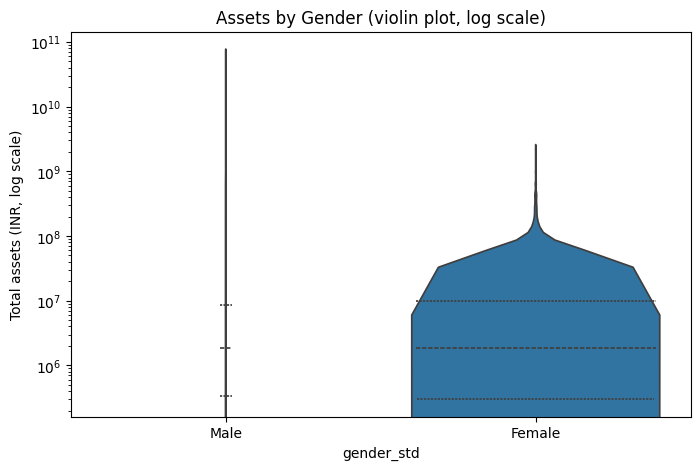

Mann-Whitney U: stat=15904235.500, p-value=0.7


2) Top 10 constituencies with most women candidates
          constituency  women_count
333  Mumbai North East           11
62            Baramati           11
115         Chandigarh           11
164           Faridkot            9
116      Chandni Chowk            9
171            Gauhati            9
238            Kairana            8
107        Bulandshahr            8
82               Betul            7
95              Bhopal            7


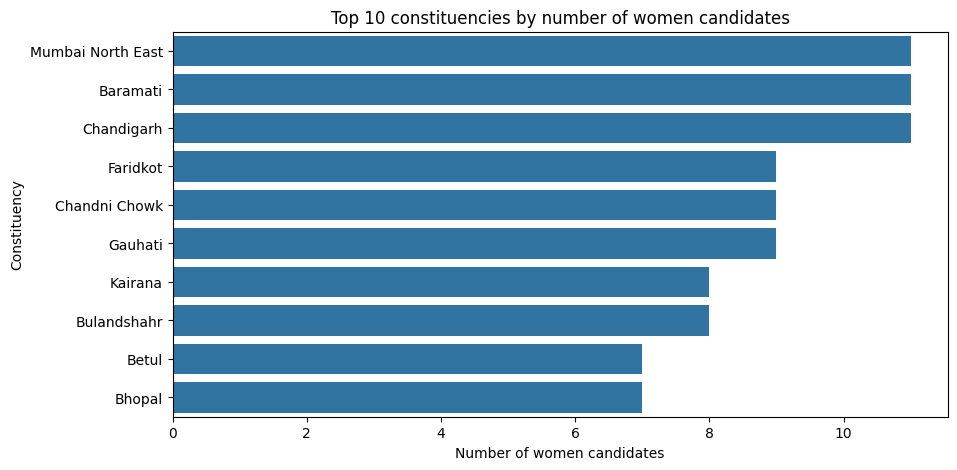



3) Party-wise women counts (filter parties with >20 candidates) and percentages vs male candidates
Parties with >20 candidates (sorted by women count):


,party,total_candidates,women,men,pct_women_of_party,pct_women_vs_men
479,IND,11725,429,11296,0.036588,0.037978
478,INC,1715,105,1610,0.061224,0.065217
186,BJP,1643,85,1558,0.051735,0.054557
224,BSP,1724,59,1665,0.034223,0.035435
1132,SP,617,27,590,0.043760,0.045763
14,AITC,260,27,233,0.103846,0.115880
782,Naam Tamilar Katchi,35,15,20,0.428571,0.750000
1140,SUCI(C),196,13,183,0.066327,0.071038
908,Pyramid Party of India,85,12,73,0.141176,0.164384
948,RPI(A),130,12,118,0.092308,0.101695



Party with maximum number of women (among parties with >20 candidates): IND
Women: 429 Total candidates: 11725 Pct women: 0.037 Women_vs_men_ratio: 0.03797804532577904


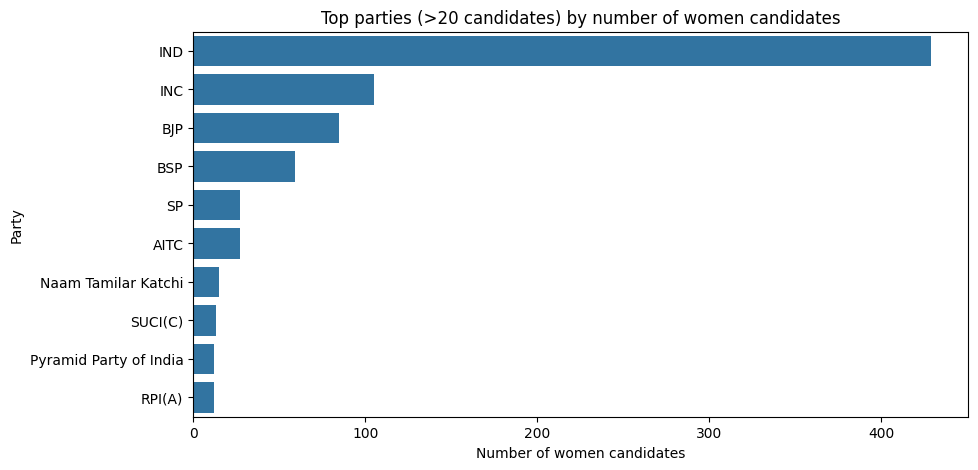



4) Total number of women candidates in all four years (and per year)
Women candidates per year:


,year_int,women_count
0,2004,207
1,2009,451
2,2019,606


Total women candidates across years: 1264


5) Educational qualifications of women candidates


,education,count,pct
0,Graduate,341,0.269778
1,Secondary,283,0.223892
2,Postgraduate,262,0.207278
3,Unknown,222,0.175633
4,Primary,87,0.068829
5,No formal education,38,0.030063
6,Doctorate,31,0.024525


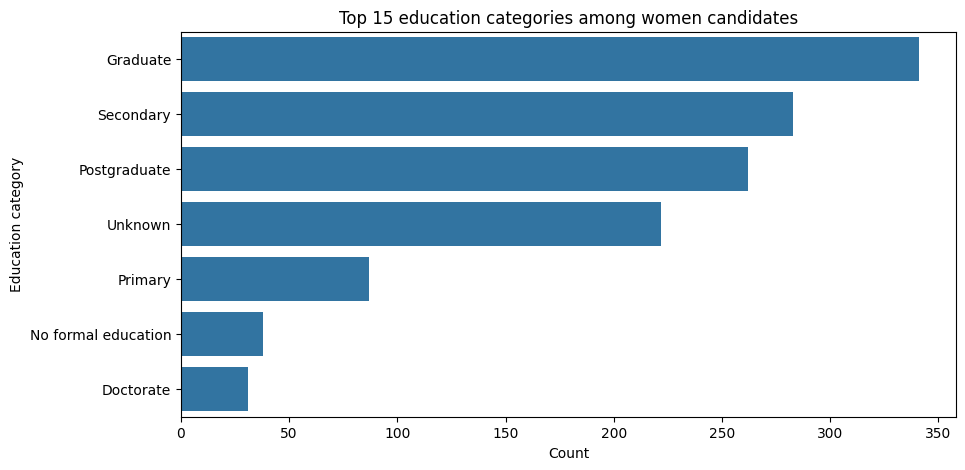



6) Same-name candidates contesting in multiple years: Men vs Women
Number of candidate NAMES who contested in multiple years (based on exact name): 2162


,candidate,years_list,years_count,genders,rows
1162,Amrit Tirkey,"[2004, 2009, 2014, 2019]",4,[Male],4
23024,Ved Prakash,"[2004, 2009, 2014, 2019]",4,[Male],7
2240,Avtar Singh Bhadana,"[2004, 2009, 2014, 2019]",4,[Male],4
21829,Sushil Kumar Singh,"[2004, 2009, 2014, 2019]",4,[Male],5
20106,Shibu Soren,"[2004, 2009, 2014, 2019]",4,[Male],4
16150,Raj Kumar,"[2004, 2009, 2014, 2019]",4,[Male],11
12965,Mulayam Singh Yadav,"[2004, 2009, 2014, 2019]",4,[Male],4
16744,Rakesh Singh,"[2004, 2009, 2014, 2019]",4,[Male],4
15673,Prof. Bhim Singh,"[2004, 2009, 2014, 2019]",4,[Male],4
1342,Anil Kumar,"[2004, 2009, 2014, 2019]",4,[Male],26



All outputs (tables + plots) saved to: /content/eda_outputs


In [5]:

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
%matplotlib inline

outdir = "/content/eda_outputs"
os.makedirs(outdir, exist_ok=True)



# --- helper to find column names robustly ---
def find_col(possible_names):
    cols = df.columns.tolist()
    for p in possible_names:
        if p in cols:
            return p
    # try substring match
    for p in possible_names:
        for c in cols:
            if p in c:
                return c
    return None

candidate_col = find_col(['candidate','name','candidate_name','candidatename','candidate_full'])
party_col = find_col(['party','partyname'])
const_col = find_col(['constituency','constituency_name','constituencyname','const'])
gender_col = find_col(['gender_std','gender','sex'])
assets_col = find_col(['total_assets_inr','total_assets','assets','totalassets'])
education_col = find_col(['education_std','education','educational_qualification'])
year_col = find_col(['year_int','year','election_year'])
criminal_col = find_col(['has_criminal_binary','has_criminal','criminal_cases_count'])
winner_col = find_col(['winner_flag','winner','iswinner'])

print("Using columns:")
print(" candidate:", candidate_col)
print(" party:", party_col)
print(" constituency:", const_col)
print(" gender:", gender_col)
print(" assets:", assets_col)
print(" education:", education_col)
print(" year:", year_col)
print(" criminal:", criminal_col)
print(" winner:", winner_col)

# ensure types
if assets_col:
    df[assets_col] = pd.to_numeric(df[assets_col], errors='coerce')
if year_col:
    df[year_col] = pd.to_numeric(df[year_col], errors='coerce')
if gender_col:
    # standardize to Title case for safe grouping
    df[gender_col] = df[gender_col].astype(str).str.strip().replace({'nan':'Unknown'}).fillna('Unknown')
if education_col:
    df[education_col] = df[education_col].astype(str).fillna('Unknown')

# Quick safe fallback names if detection failed
if not candidate_col:
    # try first object-like column
    candidate_col = df.select_dtypes(include=['object']).columns[0]
    print("Fallback candidate_col ->", candidate_col)

if not const_col:
    const_col = df.select_dtypes(include=['object']).tolist()[min(1, len(df.select_dtypes(include=['object']).columns)-1)]

# ---------- 1) women candidate asset vs men candidate asset ----------
print("\n\n1) Women candidate assets vs Men candidate assets")

if not assets_col:
    raise RuntimeError("Assets column not detected. Check your cleaned dataset.")
if not gender_col:
    raise RuntimeError("Gender column not detected. Check your cleaned dataset.")

# Subset for Male/Female only (ignore Unknown/Other for this comparison)
subset = df[df[gender_col].isin(['Male','Female'])].copy()

# Basic stats
group_stats = subset.groupby(gender_col)[assets_col].agg(['count','median','mean','std','min','max','sum']).sort_values('count',ascending=False)
print("\nAssets summary by gender:")
display(group_stats)

# Boxplot & violin (log scale for assets)
plt.figure(figsize=(8,5))
sns.violinplot(data=subset, x=gender_col, y=assets_col, inner='quartile')
plt.yscale('log')
plt.title("Assets by Gender (violin plot, log scale)")
plt.ylabel("Total assets (INR, log scale)")
plt.savefig(os.path.join(outdir,"assets_by_gender_violin.png"), dpi=150, bbox_inches='tight')
plt.show()

# Statistical test: distributions are skewed -> Mann-Whitney U
male_assets = subset[subset[gender_col]=='Male'][assets_col].dropna()
female_assets = subset[subset[gender_col]=='Female'][assets_col].dropna()
if len(male_assets) >= 10 and len(female_assets) >= 10:
    stat, p = stats.mannwhitneyu(male_assets, female_assets, alternative='two-sided')
    print(f"Mann-Whitney U: stat={stat:.3f}, p-value={p:.4g}")
else:
    print("Not enough observations for robust Mann-Whitney test (need >=10 in each group).")

# Save numeric summary
group_stats.to_csv(os.path.join(outdir,"assets_by_gender_summary.csv"))

# ---------- 2) top 10 constituencies with most number of women candidates ----------
print("\n\n2) Top 10 constituencies with most women candidates")

if not const_col:
    raise RuntimeError("Constituency column not detected.")
women = df[df[gender_col]=='Female'].copy()
top10_const = women.groupby(const_col).size().reset_index(name='women_count').sort_values('women_count', ascending=False).head(10)
print(top10_const)
top10_const.to_csv(os.path.join(outdir,"top10_constituencies_women.csv"), index=False)

# barplot
plt.figure(figsize=(10,5))
sns.barplot(data=top10_const, x='women_count', y=top10_const[const_col], orient='h')
plt.title("Top 10 constituencies by number of women candidates")
plt.xlabel("Number of women candidates")
plt.ylabel("Constituency")
plt.savefig(os.path.join(outdir,"top10_const_women_bar.png"), dpi=150, bbox_inches='tight')
plt.show()

# ---------- 3) maximum number of women candidate by party only if they have more than 20 candidates.
#     provide the percentage of women candidate vs their own male candidates ----------
print("\n\n3) Party-wise women counts (filter parties with >20 candidates) and percentages vs male candidates")

if not party_col:
    raise RuntimeError("Party column not detected.")

# ensure party string
df[party_col] = df[party_col].astype(str).str.strip()

party_summary = df.groupby(party_col).agg(
    total_candidates = (candidate_col, 'count'),
    women = (gender_col, lambda s: (s=='Female').sum()),
    men = (gender_col, lambda s: (s=='Male').sum())
).reset_index()

# filter parties with more than 20 candidates
party_filtered = party_summary[party_summary['total_candidates'] > 20].copy()
# compute percentages
party_filtered['pct_women_of_party'] = party_filtered['women'] / party_filtered['total_candidates']
party_filtered['pct_women_vs_men'] = party_filtered.apply(lambda r: (r['women'] / r['men'] if r['men']>0 else np.nan), axis=1)

# sort by women desc and show top results
party_filtered_sorted = party_filtered.sort_values('women', ascending=False)
print("Parties with >20 candidates (sorted by women count):")
display(party_filtered_sorted.head(50))
party_filtered_sorted.to_csv(os.path.join(outdir,"party_women_filtered_gt20.csv"), index=False)

# Highlight party with maximum number of women among these
if not party_filtered_sorted.empty:
    top_party = party_filtered_sorted.iloc[0]
    print(f"\nParty with maximum number of women (among parties with >20 candidates): {top_party[party_col]}")
    print("Women:", int(top_party['women']), "Total candidates:", int(top_party['total_candidates']),
          "Pct women:", f"{top_party['pct_women_of_party']:.3f}", "Women_vs_men_ratio:", top_party['pct_women_vs_men'])

# Plot top 10 parties by women count (from filtered list)
plt.figure(figsize=(10,5))
sns.barplot(data=party_filtered_sorted.head(10), x='women', y=party_col)
plt.title("Top parties (>20 candidates) by number of women candidates")
plt.xlabel("Number of women candidates")
plt.ylabel("Party")
plt.savefig(os.path.join(outdir,"top_parties_women_gt20.png"), dpi=150, bbox_inches='tight')
plt.show()

# ---------- 4) total number of women candidates in all four years? ----------
print("\n\n4) Total number of women candidates in all four years (and per year)")

if not year_col:
    print("Year column not detected; will count overall only.")
    total_women_all = int(women.shape[0])
    print("Total women candidates (all years combined):", total_women_all)
else:
    per_year = df[df[gender_col]=='Female'].groupby(year_col).size().reset_index(name='women_count').sort_values(year_col)
    total_women_all = int(per_year['women_count'].sum())
    print("Women candidates per year:")
    display(per_year)
    print("Total women candidates across years:", total_women_all)
    per_year.to_csv(os.path.join(outdir,"women_count_per_year.csv"), index=False)

# ---------- 5) Educational qualifications of the women candidates ----------
print("\n\n5) Educational qualifications of women candidates")

if not education_col:
    raise RuntimeError("Education column not detected.")
women_edu = df[df[gender_col]=='Female'][education_col].value_counts(dropna=False).reset_index()
women_edu.columns = ['education','count']
women_edu['pct'] = women_edu['count'] / women_edu['count'].sum()
display(women_edu.head(50))
women_edu.to_csv(os.path.join(outdir,"women_education_distribution.csv"), index=False)

# barplot (top 15)
plt.figure(figsize=(10,5))
sns.barplot(data=women_edu.head(15), x='count', y='education')
plt.title("Top 15 education categories among women candidates")
plt.xlabel("Count")
plt.ylabel("Education category")
plt.savefig(os.path.join(outdir,"women_education_top15.png"), dpi=150, bbox_inches='tight')
plt.show()

# ---------- 6) same person contesting different years Men vs women candidates ----------
print("\n\n6) Same-name candidates contesting in multiple years: Men vs Women")

# We'll use exact candidate name matches. NOTE: identical names can be different people.
# Build a table of candidate name -> unique years contested -> genders observed
# if you have additional disambiguators (constituency, party), you can extend the key.
df[candidate_col] = df[candidate_col].astype(str).str.strip()

# find names that appear in more than one year
if not year_col:
    print("Year column not available; cannot compute multi-year contests.")
else:
    # group by candidate and collect unique years and genders
    candidate_group = df.groupby(candidate_col).agg(
        years_list = (year_col, lambda s: sorted(s.dropna().unique().tolist())),
        years_count = (year_col, lambda s: s.dropna().nunique()),
        genders = (gender_col, lambda s: sorted(set([x for x in s.dropna().astype(str).tolist()]))),
        rows = (candidate_col, 'count')
    ).reset_index()

    multi_year = candidate_group[candidate_group['years_count'] > 1].sort_values('years_count', ascending=False)
    print("Number of candidate NAMES who contested in multiple years (based on exact name):", multi_year.shape[0])
    # Show top examples (most years)
    display(multi_year.head(50))
    multi_year.to_csv(os.path.join(outdir,"candidates_multi_year_exactname.csv"), index=False)



# ---- Done ----
print("\nAll outputs (tables + plots) saved to:", outdir)
